In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from zipfile import ZipFile

%matplotlib inline

In [2]:
with ZipFile('data/_train_sem09__1_.zip') as myzip:
    df = pd.read_csv(myzip.open('_train_sem09 (1).csv'))
df.head(3)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0


In [3]:
RANDOM_STATE = 42
N_SPLITS = 5

In [4]:
# Создаем матрицу наблюдений X и вектор ответов y, разбиваем на обучающую и тестовую выборки
X = df.drop(['Activity'], axis=1)
y = df['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

In [5]:
# Базовая модель с дефолтными гиперпараметрами, задача бинарной классификации
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(rf.score(X_test, y_test)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.786
f1_score на тестовом наборе: 0.805


Базовая модель случайного леса с дефолтными параметрами показала на тестовой выборке лучший результат, чем логистическая регрессия.

In [6]:
# подбор гиперпараметров с применением GridSearchCV
param_grid = {
            'n_estimators': list(np.linspace(80, 320, 7, dtype=int)),
            'min_samples_leaf': list(np.linspace(1, 5, 5, dtype=int)),
            'max_depth': list(np.linspace(10, 40, 4, dtype=int))
}
# применим  cross validation с количеством фолдов N_SPLITS
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=RANDOM_STATE), 
    param_grid=param_grid, 
    cv=skf, 
    n_jobs = -1
)   
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.3f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 4.23 s
Wall time: 5min 7s
accuracy на тестовом наборе: 0.783
f1_score на тестовом наборе: 0.803
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 120}


GridSearchCV не улучшил результат базовой модели на тестовой выборке

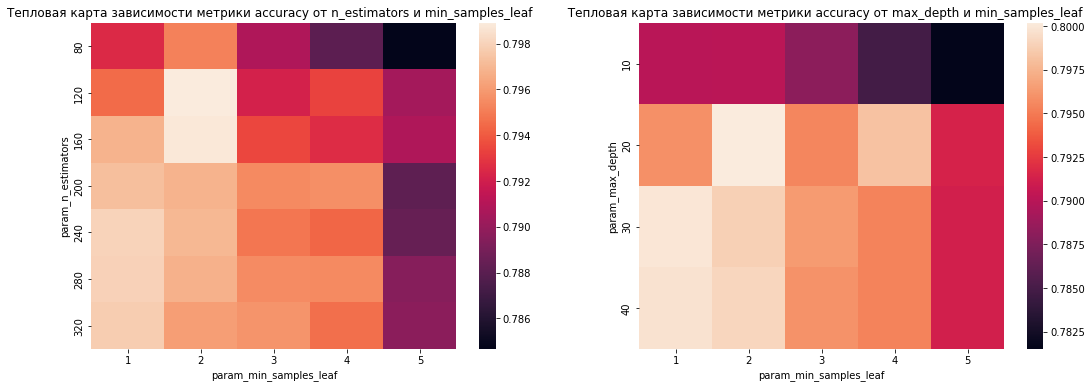

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
visual_1 = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_n_estimators',
                        columns='param_min_samples_leaf')
ax1 = sns.heatmap(visual_1, ax=axes[0])
ax1.set_title('Тепловая карта зависимости метрики accuracy от n_estimators и min_samples_leaf  ')
visual_2 = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_max_depth',
                        columns='param_min_samples_leaf')
ax2 = sns.heatmap(visual_2, ax=axes[1])
ax2.set_title('  Тепловая карта зависимости метрики accuracy от max_depth и min_samples_leaf');

Но при этом GridSearchCV выделил области оптимальных гиперпараметров

In [8]:
# подбор гиперпараметров с применением RandomizedSearchCV
param_distributions = {
            'n_estimators': list(np.linspace(80, 320, 241, dtype=int)),
            'min_samples_leaf': list(np.linspace(1, 5, 5, dtype=int)),
            'max_depth': list(np.linspace(10, 40, 31, dtype=int))
}
# применим  cross validation с количеством фолдов N_SPLITS
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
random_search = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=RANDOM_STATE), 
    param_distributions=param_distributions, 
    cv=skf, 
    n_iter = 30, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.3f}".format(random_search.score(X_test, y_test)))
y_test_rs_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_rs_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 5.17 s
Wall time: 1min 16s
accuracy на тестовом наборе: 0.790
f1_score на тестовом наборе: 0.808
Наилучшие значения гиперпараметров: {'n_estimators': 302, 'min_samples_leaf': 1, 'max_depth': 26}


Поиск RandomizedSearchCV улучшил показатель базовой модели на 3 тысячных.

In [9]:
# функция для подбора гиперпараметров с применением Hyperopt
def hyperopt_rf(params, X=X_train, y=y_train, n_splits=N_SPLITS, random_state=RANDOM_STATE):
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    model.fit(X, y)
    # применим  cross validation с количеством фолдов, переданным в функцию
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    score = cross_val_score(model, X, y, cv=skf, scoring="f1", n_jobs=-1).mean()
    return {'loss': -score, 'params': params, 'status': STATUS_OK}

In [10]:
%%time
# подбор гиперпараметров с применением Hyperopt
space = {
    'n_estimators': hp.choice('n_estimators', list(np.linspace(80, 320, 241, dtype=int))), # == hp.randint('n_estimators', 80, 321)
    'min_samples_leaf': hp.choice('min_samples_leaf', list(np.linspace(1, 5, 5, dtype=int))), # == hp.randint('min_samples_leaf', 1, 6)
    'max_depth' : hp.choice('max_depth', list(np.linspace(10, 40, 31, dtype=int))) # == hp.randint('max_depth', 10, 41)
}
trials = Trials() # логирование результатов
best = fmin(hyperopt_rf, # функция 
            space=space, # пространство гиперпараметров
            algo=tpe.suggest, # алгоритм байесовской оптимизации TPE
            max_evals=20, # максимальное количество итераций
            trials=trials,
            rstate=np.random.default_rng(RANDOM_STATE)
            )
print("Наилучшие значения гиперпараметров {}".format(trials.best_trial['result']['params']))

100%|██████████| 20/20 [02:39<00:00,  7.97s/trial, best loss: -0.8186245311821123]
Наилучшие значения гиперпараметров {'max_depth': 34, 'min_samples_leaf': 1, 'n_estimators': 194}
CPU times: total: 47.6 s
Wall time: 2min 39s


In [11]:
# Модель с гиперпараметрами, подобранными Hyperopt 
hyp_search = ensemble.RandomForestClassifier(n_estimators=trials.best_trial['result']['params']['n_estimators'],
                                            min_samples_leaf=trials.best_trial['result']['params']['min_samples_leaf'],
                                            max_depth=trials.best_trial['result']['params']['max_depth'],
                                            random_state=RANDOM_STATE)
hyp_search.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(hyp_search.score(X_test, y_test)))
y_test_pred = hyp_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.787
f1_score на тестовом наборе: 0.806


Hyperopt улучшил результат базовой модели на тестовых данных на одну тысячную.

In [12]:
%%time
# добавим еще 10 итераций
best = fmin(hyperopt_rf, # функция 
        space=space, # пространство гиперпараметров
        algo=tpe.suggest, # алгоритм байесовской оптимизации TPE
        max_evals=30, # максимальное количество итераций
        trials=trials,
        rstate=np.random.default_rng(RANDOM_STATE)
        )
print("Наилучшие значения гиперпараметров {}".format(trials.best_trial['result']['params']))
hyp_search = ensemble.RandomForestClassifier(n_estimators=trials.best_trial['result']['params']['n_estimators'],
                                            min_samples_leaf=trials.best_trial['result']['params']['min_samples_leaf'],
                                            max_depth=trials.best_trial['result']['params']['max_depth'],
                                            random_state=RANDOM_STATE)
hyp_search.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(hyp_search.score(X_test, y_test)))
y_test_pred = hyp_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 30/30 [01:22<00:00,  8.21s/trial, best loss: -0.8245053142316081]
Наилучшие значения гиперпараметров {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 309}
accuracy на тестовом наборе: 0.792
f1_score на тестовом наборе: 0.810
CPU times: total: 26.5 s
Wall time: 1min 28s


Получилось улучшить f1_score на тестовом наборе еще на 4 тысячных.

In [13]:
# функция для подбора гиперпараметров с применением Optuna
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 80, 320, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5, 1)
    max_depth = trial.suggest_int('max_depth', 10, 40, 1)
    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,  
                                            min_samples_leaf=min_samples_leaf,
                                            max_depth=max_depth,
                                            random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    # применим  cross validation с количеством фолдов N_SPLITS
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(model, X, y, cv=skf, scoring="f1", n_jobs=-1).mean()
    return score

In [14]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)
print("Лучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study.best_value))

[I 2023-04-29 17:40:52,381] A new study created in memory with name: RandomForestClassifier
[I 2023-04-29 17:40:59,982] Trial 0 finished with value: 0.8148845961848336 and parameters: {'n_estimators': 110, 'min_samples_leaf': 1, 'max_depth': 29}. Best is trial 0 with value: 0.8148845961848336.
[I 2023-04-29 17:41:10,653] Trial 1 finished with value: 0.8109025963509916 and parameters: {'n_estimators': 253, 'min_samples_leaf': 5, 'max_depth': 38}. Best is trial 0 with value: 0.8148845961848336.
[I 2023-04-29 17:41:20,512] Trial 2 finished with value: 0.8162365689288915 and parameters: {'n_estimators': 217, 'min_samples_leaf': 2, 'max_depth': 34}. Best is trial 2 with value: 0.8162365689288915.
[I 2023-04-29 17:41:26,859] Trial 3 finished with value: 0.8118304277678299 and parameters: {'n_estimators': 162, 'min_samples_leaf': 5, 'max_depth': 40}. Best is trial 2 with value: 0.8162365689288915.
[I 2023-04-29 17:41:34,429] Trial 4 finished with value: 0.8140555824069496 and parameters: {'n_

Лучшие значения гиперпараметров {'n_estimators': 287, 'min_samples_leaf': 1, 'max_depth': 17}
f1_score на обучающем наборе: 0.823
CPU times: total: 1min 4s
Wall time: 3min 35s


In [15]:
# Модель с гиперпараметрами, подобранными Optuna
opt_rf = ensemble.RandomForestClassifier(**study.best_params, random_state=RANDOM_STATE)
opt_rf.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(opt_rf.score(X_test, y_test)))
y_test_pred = opt_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.794
f1_score на тестовом наборе: 0.812


С помощью Optuna еще улучшили результат на тестовой выборке.

In [16]:
%%time
# добавим еще 10 итераций
study.optimize(optuna_rf, n_trials=10)
print("Лучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study.best_value))
opt_rf = ensemble.RandomForestClassifier(**study.best_params, random_state=RANDOM_STATE)
opt_rf.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(opt_rf.score(X_test, y_test)))
y_test_pred = opt_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-04-29 17:51:06,577] Trial 20 finished with value: 0.8123665110909928 and parameters: {'n_estimators': 84, 'min_samples_leaf': 3, 'max_depth': 13}. Best is trial 8 with value: 0.823173900602009.
[I 2023-04-29 17:51:22,911] Trial 21 finished with value: 0.8190426979611278 and parameters: {'n_estimators': 304, 'min_samples_leaf': 2, 'max_depth': 27}. Best is trial 8 with value: 0.823173900602009.
[I 2023-04-29 17:51:38,720] Trial 22 finished with value: 0.8215460138599647 and parameters: {'n_estimators': 299, 'min_samples_leaf': 1, 'max_depth': 33}. Best is trial 8 with value: 0.823173900602009.
[I 2023-04-29 17:51:50,197] Trial 23 finished with value: 0.8169921222524017 and parameters: {'n_estimators': 235, 'min_samples_leaf': 1, 'max_depth': 33}. Best is trial 8 with value: 0.823173900602009.
[I 2023-04-29 17:52:03,107] Trial 24 finished with value: 0.8199729641702197 and parameters: {'n_estimators': 265, 'min_samples_leaf': 1, 'max_depth': 32}. Best is trial 8 with value: 0.823

Лучшие значения гиперпараметров {'n_estimators': 287, 'min_samples_leaf': 1, 'max_depth': 17}
f1_score на обучающем наборе: 0.823
accuracy на тестовом наборе: 0.794
f1_score на тестовом наборе: 0.812
CPU times: total: 34.2 s
Wall time: 2min 15s


Дополнительные 10 итераций не изменили лучший результат.

In [17]:
optuna.visualization.is_available()

True

In [18]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [19]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [20]:
optuna.visualization.plot_contour(study, params=["max_depth", "min_samples_leaf"], target_name="f1_score")

In [21]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"], target_name="f1_score")

Итак, лучшие результаты оптимизаторов:

- GridSearchCV  {'n_estimators': 120, 'min_samples_leaf': 2, 'max_depth': 20}   0.803

- RandomizedSearchCV   {'n_estimators': 302, 'min_samples_leaf': 1, 'max_depth': 26}   0.808

- Hyperopt   {'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 309}   0.810

- Optuna   {'n_estimators': 287, 'min_samples_leaf': 1, 'max_depth': 17}   0.812

Видно, что полученные тремя последними оптимизаторами гиперпараметры близки между собой, и только GridSearchCV, близко подойдя с 'max_depth' и 'min_samples_leaf', по количеству деревьев попал в другой локальный максимум, который, кстати, так же определяется на визуализации Optuna.

После оптимизации гиперпараметров модель, обученная RandomForestClassifier, показала лучший результат, чем обученная LogisticRegression: f1_score на тестовой выборке 0.812 против 0.786.